## Burgers 1D PINN

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn

**Define Neural Network**

In [2]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 20), # 2 inputs and 20 neurons
            nn.Tanh(),
            nn.Linear(20, 30),
            nn.Tanh(),
            nn.Linear(30, 30),
            nn.Tanh(),
            nn.Linear(30, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        output = self.net(x)
        return output

**Boundary Conditions**

In [9]:
class Net:
    def __init__(self):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        self.model = NN().to(device)

        # Comp. domain
        self.h = 0.1 # Step size of space
        self.k = 0.1 # Step size of time
        x = torch.arange(-1, 1+self.h, self.h)
        t = torch.arange(0, 1+self.k, self.k)
        
        self.X = torch.stack(torch.meshgrid(x, t)).view(2, -1).T

        # B.C and I.C
        bc1 = torch.stack(torch.meshgrid(x[0], t)).reshape(2, -1).T
        bc2 = torch.stack(torch.meshgrid(x[-1], t)).reshape(2, -1).T
        ic = torch.stack(torch.meshgrid(x, t[0])).reshape(2, -1).T

        # Train data
        self.X_train = torch.cat([bc1, bc2, ic])

        y_bc1 = torch.zeros(len(bc1))
        y_bc2 = torch.zeros(len(bc2))
        y_ic = -torch.sin(torch.pi * ic[:, 0])
        self.y_train = torch.cat([y_bc1, y_bc2, y_ic])
        self.y_train = self.y_train.unsqueeze(1)

        self.X = self.X.to(device)
        self.y_train = self.y_train.to(device)
        self.X_train = self.X_train.to(device)
        self.X.requires_grad = True 

        # Optimizer
        self.adam = torch.optim.Adam(self.model.parameters())
        # Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS)
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(),
            lr=1.0,
            max_iter=50000,
            max_eval=50000,
            history_size=50,
            tolerance_grad=1e-7,
            tolerance_change=1.0*np.finfo(float).eps,
            line_search_fn="strong_wolfe"
        )

        self.criterion = torch.nn.MSELoss()
        self.iter = 1

    def loss_func(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        y_pred = self.model(self.X_train)
        loss_data = self.criterion(y_pred, self.y_train)

        u = self.model(self.X)

        du_dX = torch.autograd.grad(u, 
                                    self.X, 
                                    grad_outputs=torch.ones_like(u), 
                                    create_graph=True,
                                    retain_graph=True)[0]
        
        du_dx = du_dX[:, 0]
        du_dt = du_dX[:, 1]

        du_dXX = torch.autograd.grad(du_dX, 
                                    self.X, 
                                    grad_outputs=torch.ones_like(du_dX), 
                                    create_graph=True,
                                    retain_graph=True)[0]
        
        du_dxx = du_dXX[:, 0]

        loss_pde = self.criterion(du_dt + u.squeeze()*du_dx, (0.01/torch.pi * du_dxx))

        loss = loss_pde + loss_data
        loss.backward()

        if self.iter % 100 == 0:
            print(f"Iteration: {self.iter}, Train loss: {loss.item()}")
        self.iter += 1
        return loss
    
    def train(self):
        self.model.train()
        for i in range(1000):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)

    def eval(self):
        self.model.eval()

In [10]:
net = Net()
net.train()

Iteration: 100, Train loss: 0.15638674795627594
Iteration: 200, Train loss: 0.09086780250072479
Iteration: 300, Train loss: 0.07169057428836823
Iteration: 400, Train loss: 0.05886133760213852
Iteration: 500, Train loss: 0.037197694182395935
Iteration: 600, Train loss: 0.019676046445965767
Iteration: 700, Train loss: 0.014790421351790428
Iteration: 800, Train loss: 0.012265698984265327
Iteration: 900, Train loss: 0.010294850915670395
Iteration: 1000, Train loss: 0.00963811855763197
Iteration: 1100, Train loss: 0.004702324979007244
Iteration: 1200, Train loss: 0.002829480916261673
Iteration: 1300, Train loss: 0.0019840789027512074
Iteration: 1400, Train loss: 0.0013130175648257136
Iteration: 1500, Train loss: 0.0008938548853620887
Iteration: 1600, Train loss: 0.000745269178878516
Iteration: 1700, Train loss: 0.00065171456662938
Iteration: 1800, Train loss: 0.0005350562860257924
Iteration: 1900, Train loss: 0.000460682698758319
Iteration: 2000, Train loss: 0.0003861375153064728
Iteration:

In [11]:
net.model.eval()

NN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=30, bias=True)
    (3): Tanh()
    (4): Linear(in_features=30, out_features=30, bias=True)
    (5): Tanh()
    (6): Linear(in_features=30, out_features=20, bias=True)
    (7): Tanh()
    (8): Linear(in_features=20, out_features=20, bias=True)
    (9): Tanh()
    (10): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [23]:
model = NN()
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters: {total_params}')

Total number of parameters: 2681


In [20]:
h = 0.01
k = 0.01

x = torch.arange(-1, 1, h)
t = torch.arange(0, 1, k)

X = torch.stack(torch.meshgrid(x, t)).reshape(2, -1).T
X = X.to(net.X.device)

In [22]:
X.shape

torch.Size([20000, 2])

In [24]:
model = net.model
model.eval()
with torch.no_grad():
    y_pred = model(X)
    y_pred = y_pred.reshape(len(x), len(t)).cpu().numpy()

In [25]:
sns.set_style("white")
plt.figure(figsize=(5, 3), dpi=3000)
sns.heatmap(y_pred, cmap="jet")

<Axes: >

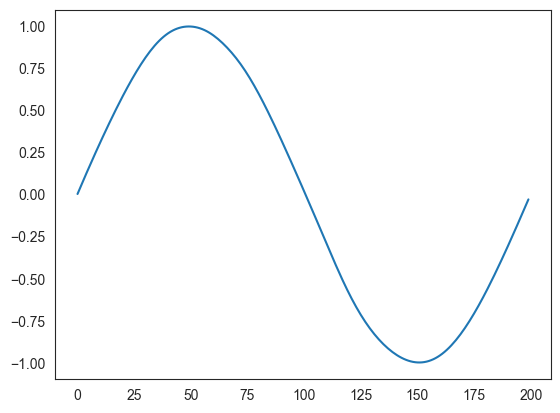

In [26]:
plt.plot(y_pred[:, 0])